In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from skimage import transform
from torchvision import utils
from sklearn import model_selection
import torch.nn as nn
from torchvision.models import vgg16

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
class MudraDataset(Dataset):
    def __init__(self, root_dir, state='All', transform=None):
        #"""
        #Args:
            #csv_files (string): Path to the csv file with annotations
            #root_dir (string): Directory with all the images
            #transform (callable, optional): Optional transform to be applied on a sample
        #"""
        #self.mudraJoints = pd.read_csv(csv_file)
        self.state = state
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.X_data = []
        self.Y_data = []
        
        if os.path.isdir(root_dir):
            for dirs in os.listdir(root_dir):
                #print(dirs)
                full_path = os.path.join(root_dir, dirs)
                csv_path = os.path.join(full_path, 'Annotation.csv')
                csv_file = pd.read_csv(csv_path)
                for i, row in csv_file.iterrows():
                    img_path = os.path.join(full_path, row[0])
                    #print(img_path)
                    image = img_path
                    self.X_data.append(image)
                    jointAngle = row[1:]
                    jointAngle = np.array([jointAngle])
                    jointAngle = jointAngle.astype('float')
                    self.Y_data.append(jointAngle)
                    #sample = {'image': image, 'jointAngle': jointAngle}
                    #self.data.append(sample)

        X_train, X_test, Y_train, Y_test = model_selection.train_test_split(self.X_data,
                                                self.Y_data, test_size=0.25, random_state=42)
        if state == 'Train':    
            self.X_data, self.Y_data = X_train, Y_train
        elif state == 'Test':
            self.X_data, self.Y_data = X_test, Y_test
    
    def __len__(self):
        return len(self.X_data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        #img_name = os.path.join(self.root_dir, self.mudraJoints.iloc[idx, 0])
        #image = cv2.imread(img_name)
        #jointCood = self.mudraJoints.iloc[idx, 1:]
        #jointCood = np.array([jointCood])
        #jointCood = jointCood.astype('float')#.reshape(-1,2)
        #print(self.X_data[i])
        #print(self.X_data[idx])
        sample = {'image': cv2.imread(self.X_data[idx]).astype('float'), 'jointCood': self.Y_data[idx]}
        
        if self.transform:
            sample = self.transform(sample)
        return sample

In [3]:
mudra_dataset = MudraDataset(root_dir='/home/soumen/2nd/Mudra Dataset/Single hand', state='All')
fig = plt.figure()

for i in range(len(mudra_dataset)):
    sample = mudra_dataset[i]
    
    print(i, sample['image'].shape, sample['jointCood'].shape)
    
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    if i==3:
        plt.show()
        break

ValueError: With n_samples=0, test_size=0.25 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [3]:
#Data Preprocessing Rescale, RandomCrop, and ToTensor
class Rescale(object):
    #Args:
    #output_size (tuple or int): Desired output size. If tuple, output is matched to output size. It int, smaller of
    #image edges is matched to output_size keeping aspect ratio the same
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, joints = sample['image'], sample['jointCood']
        #print(image)
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        
        return {'image': img, 'jointCood': joints}
    
class RandomCrop(object):
    #Args:
    #output_size (tuple or int): Desired output size. If int, square crop is made

    def __init__(self, output_size):
        assert isinstance(output_size, (tuple, int))

        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, joints = sample['image'], sample['jointCood']
        #print(image)
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]

        return {'image': image, 'jointCood': joints}

class ToTensor(object):
    #Convert numpy array image to tensor image

    def __call__(self, sample):
        image, joints = sample['image'], sample['jointCood']

        #swap color axis because
        #numpy image: H * W * C
        #torch image: C * H * W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).to(torch.float), 'jointCood': torch.from_numpy(joints).to(torch.float)}

In [4]:
scale = Rescale((227,227))
#composed = transforms.Compose([scale, ToTensor()])

train_dataset = MudraDataset(root_dir='Mudra Dataset/Single hand', state='Train',
                                  transform=transforms.Compose([Rescale((227,227)), ToTensor()]))

test_dataset = MudraDataset(root_dir='Mudra Dataset/Single hand', state='Test',
                                  transform=transforms.Compose([Rescale((227,227)), ToTensor()]))

val_dataset = MudraDataset(root_dir='Mudra Dataset/Single hand', state='Train',
                                  transform=transforms.Compose([Rescale((227,227)), ToTensor()]))

Mudra Dataset/Single hand/Chatura/277.jpg
Mudra Dataset/Single hand/Ardhachandra/320.jpg
Mudra Dataset/Single hand/Chandrakala/54.jpg
Mudra Dataset/Single hand/Hamsasya/335.jpg
0 torch.Size([4, 3, 227, 227]) torch.Size([4, 1, 14])
Mudra Dataset/Single hand/Chatura/258.jpg
Mudra Dataset/Single hand/Arala/506.jpg
Mudra Dataset/Single hand/Bhramara/374.jpg
Mudra Dataset/Single hand/Ardhachandra/254.jpg
1 torch.Size([4, 3, 227, 227]) torch.Size([4, 1, 14])
Mudra Dataset/Single hand/Kapitta/114.jpg
Mudra Dataset/Single hand/Chatura/95.jpg
Mudra Dataset/Single hand/Alapadma/456.jpg
Mudra Dataset/Single hand/Ardhapataaka/149.jpg
2 torch.Size([4, 3, 227, 227]) torch.Size([4, 1, 14])
Mudra Dataset/Single hand/Bhramara/172.jpg
Mudra Dataset/Single hand/Hamsasya/472.jpg
Mudra Dataset/Single hand/Ardhachandra/365.jpg
Mudra Dataset/Single hand/Kangula/311.jpg
3 torch.Size([4, 3, 227, 227]) torch.Size([4, 1, 14])
[60.  0. 90. 90.  0. 90.  0.  0. 30.  0.  0.  0.  0.  0.]
[90.  0. 90.  0.  0. 60.  0. 

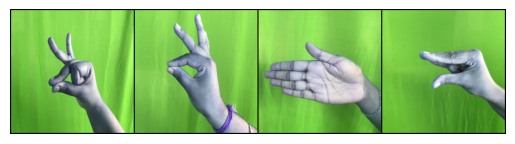

In [24]:
dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)

#Helper function to show a batch
def show_joint_batch(sample_batched):
    image_batch, joint_batch = \
                sample_batched['image'], sample_batched['jointCood']
    batch_size = len(image_batch)
    im_size = image_batch.size(2)
    grid_border_size = 2
    
    grid = utils.make_grid(image_batch)
    plt.imshow(grid.numpy().transpose((1,2,0)))
    
    for i in range(batch_size):
        print(joint_batch[i, 0, :].numpy())
        #plt.scatter(joint_batch[i, :, 0].numpy() + i * im_size + (i+1) * grid_border_size,
        #           joint_batch[i, :, 1].numpy() + grid_border_size, s=10, marker='.', c='r')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(), sample_batched['jointCood'].size())
    
    if i_batch == 3:
        plt.figure()
        show_joint_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [5]:
def data_loader(batch_size, random_seed=42, valid_size=0.1, shuffle=True, test=False):
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=valid_sampler)
    
    if test:
        return torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
    else:
        return (train_loader, valid_loader)

In [6]:
train_loader, valid_loader = data_loader(batch_size=16)
test_loader = data_loader(batch_size=16, test=True)

In [7]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        '''
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(64), nn.ReLU())
        
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
                        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(128), nn.ReLU())
        
        self.layer4 = nn.Sequential(
                        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        '''
        self.layer = vgg16(pretrained=True).features[:31]
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
    
    def forward(self, x):
        '''
        out = self.layer1(x)
        
        out = self.layer2(out)
        
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        '''
        out = self.layer(x)
        #print(out.shape)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        
        out = self.fc1(out)
        
        out = self.fc2(out)
        
        return out

In [35]:
model = VGG16(14)
x = torch.rand((1,3,227,227))
out = model(x)
print(out.shape)

torch.Size([1, 14])


In [43]:
num_classes = 14
num_epochs = 1
batch_size = 16
learning_rate = 0.0001

model = VGG16(num_classes).to(device)

#Loss and optimizier
criterion = nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.005, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    loses=0.0
    for i, sample in enumerate(train_loader):    #(images, labels)
        #Move tensors to the configured device
        #print(i)
        images = sample['image'].to(device)
        labels = sample['jointCood'].to(device)
        labels = labels.reshape([labels.shape[0],labels.shape[2]])
        #print(labels.shape)
        #Forward pass
        outputs = model(images)
        #print(outputs.shape)
        loss = criterion(outputs.data, labels)
        
        #Backward and optimize
        optimizer.zero_grad()
        loss.requires_grad = True
        loss.backward()
        optimizer.step()
        loses+=loss.item()
        images = sample['image'].to('cpu')
        labels = sample['jointCood'].to('cpu')
    
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loses/total_step))

    #Validation
    tot_loss = 0.0
    with torch.no_grad():
        correct=0
        total=0
        for i, sample in enumerate(valid_loader):
            #print(sample['image'].type)
            images = sample['image'].to(device)
            labels = sample['jointCood'].to(device)
            #print(images.type)
            outputs = model(images)
            #diff = labels - outputs.data
            val_loss = criterion(outputs.data, labels)
            val_loss.requires_grad = True
            val_loss.backward()
            tot_loss += val_loss.item()
            del images, labels, outputs
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, tot_loss)) 

/home/soumen/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/soumen/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Step [245/245], Loss: 2382.1203


/home/soumen/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([16, 1, 14])) that is different to the input size (torch.Size([16, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/soumen/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([2, 1, 14])) that is different to the input size (torch.Size([2, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Accuracy of the network on the 5000 validation images: 66391.84777832031 %
Epoch [2/50], Step [245/245], Loss: 2380.4756
Accuracy of the network on the 5000 validation images: 67476.65454101562 %
Epoch [3/50], Step [245/245], Loss: 2381.4761
Accuracy of the network on the 5000 validation images: 66030.09069824219 %
Epoch [4/50], Step [245/245], Loss: 2380.9889
Accuracy of the network on the 5000 validation images: 69822.62438964844 %
Epoch [5/50], Step [245/245], Loss: 2381.6253
Accuracy of the network on the 5000 validation images: 68099.74792480469 %
Epoch [6/50], Step [245/245], Loss: 2378.5998
Accuracy of the network on the 5000 validation images: 66076.7777709961 %
Epoch [7/50], Step [245/245], Loss: 2379.7620
Accuracy of the network on the 5000 validation images: 66785.58703613281 %
Epoch [8/50], Step [245/245], Loss: 2380.2973
Accuracy of the network on the 5000 validation images: 67692.681640625 %
Epoch [9/50], Step [245/245], Loss: 2378.3218
Accuracy of the network on the 5000